In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
from scipy import ndimage as ndi
#from skimage import data, util, filters, color
#from skimage.segmentation import watershed


def read_data(id):
    # Leer el archivo de datos correspondiente al id de la galaxia
    file_path = f'../DATA/processed/TracingPoints/data_rho_{id}_filtered.csv'
    data = pd.read_csv(file_path)
    return data

def sort_by_delta_rho(data):
    # Ordenar las partículas por deltaRho en orden decreciente
    sorted_data = data.sort_values(by='deltaRho', ascending=False).reset_index(drop=True)
    return sorted_data

# Colores
h_alpha_color = '#DC143C'  # emisiones H-alpha - Carmesí o rojo 

In [5]:
id_halo = 11
data = read_data(id_halo)

sorted_data = sort_by_delta_rho(data)

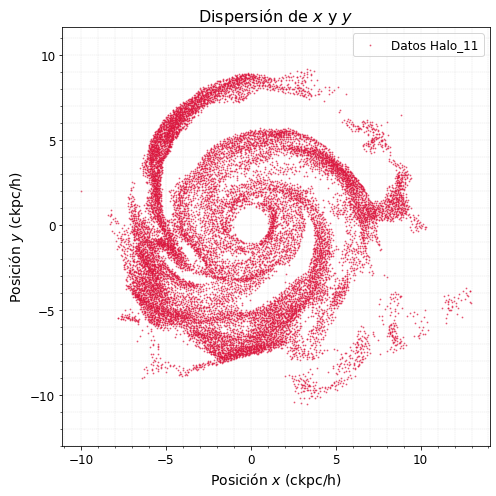

In [6]:
x = sorted_data['x']
y = sorted_data['y']

# Figura x,y halo
fig, ax = plt.subplots(figsize=(7, 7))

scatter = ax.scatter(x, y, c=h_alpha_color, s=0.7, alpha=0.6, label=f'Datos Halo_{id_halo}')

ax.set_title(r'Dispersión de $x$ y $y$', fontsize=16)
ax.set_xlabel(r'Posición $x$ (ckpc/h)', fontsize=14)
ax.set_ylabel(r'Posición $y$ (ckpc/h)', fontsize=14)
ax.legend(loc='best', fontsize=12)

ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.axis('equal')

plt.tight_layout()
plt.show()


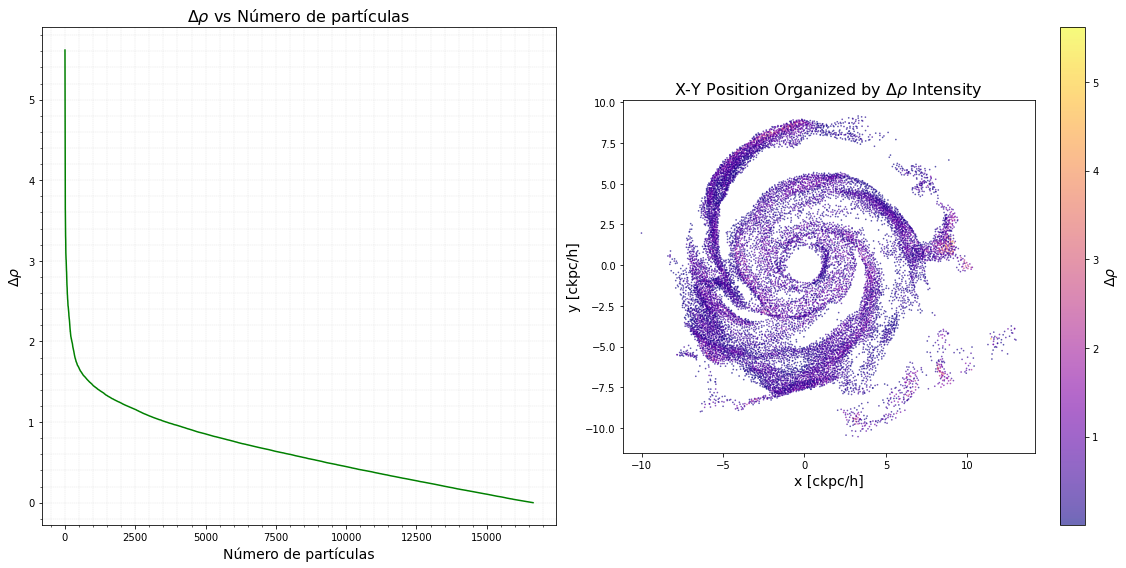

In [7]:
# Datos
x = sorted_data['x']
y = sorted_data['y']
delta_rho = sorted_data['deltaRho']
num_particles = range(1, len(delta_rho) + 1)

# Gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: DeltaRho vs Número de partículas
ax1.plot(num_particles, delta_rho, color='g', linewidth=1.5)
ax1.set_title(r'$\Delta \rho$ vs Número de partículas', fontsize=16)
ax1.set_xlabel(r'Número de partículas', fontsize=14)
ax1.set_ylabel(r'$\Delta \rho$', fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()

# Segundo gráfico: Posición X-Y de las partículas, organizadas por la intensidad de DeltaRho
scatter = ax2.scatter(x, y, c=delta_rho, cmap='plasma', s=0.5, alpha=0.6)
ax2.set_title(r'X-Y Position Organized by $\Delta \rho$ Intensity', fontsize=16)
ax2.set_xlabel('x [ckpc/h]', fontsize=14)
ax2.set_ylabel('y [ckpc/h]', fontsize=14)
ax2.set_aspect('equal', adjustable='box')

# Barra de color
cbar = fig.colorbar(scatter, ax=ax2, orientation='vertical')
cbar.set_label(r'$\Delta \rho$', fontsize=14)


plt.tight_layout()
plt.show()


## Cartesian to Polar Transformations
To transform Cartesian coordinates \((x, y)\) into polar coordinates \((r, $\phi$)\), we use the following mathematical relationships:

$$
r = \sqrt{x^2 + y^2}
$$

$$
\phi = \text{atan2}(y, x)
$$

Here, \( r \) is the radial distance from the origin, and \( $\phi$ \) is the angle (in radians) measured counterclockwise from the positive \(x\)-axis.


## Inverse Polar to Cartesian:
These transformations:

$$
x = r \cdot \cos(\phi)
$$
$$
y = r \cdot \sin(\phi)
$$


In [8]:
#funciones

def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates (x, y) to polar coordinates (r, phi).
    
    Parameters:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    
    Returns:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    """
    # Calculate radial distance
    r = np.sqrt(x**2 + y**2)
    
    # Calculate the angle using atan2 (handles all quadrants)
    phi = np.arctan2(y, x)
    
    return r, phi


def polar_to_cartesian(r, phi):
    """
    Convert polar coordinates (r, phi) to Cartesian coordinates (x, y).
    
    Parameters:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    
    Returns:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    """
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    
    return x, y


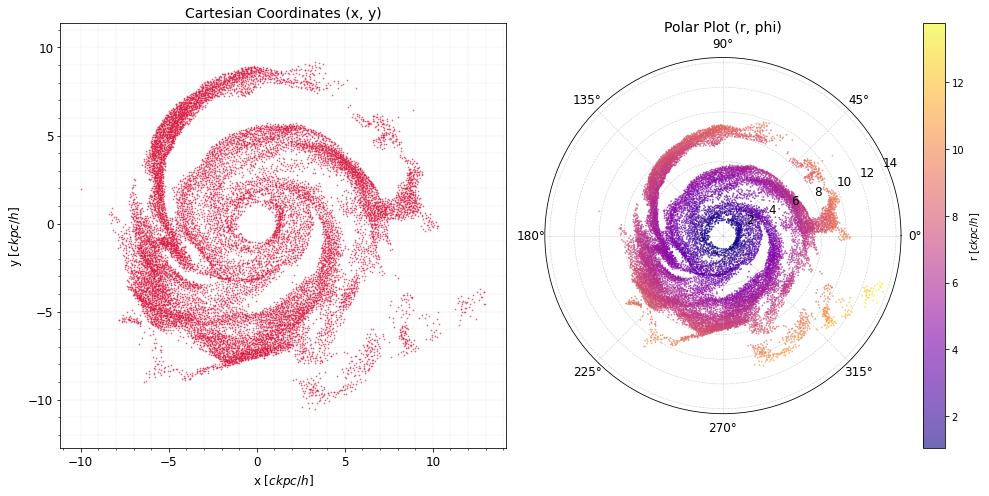

In [14]:

x_values = sorted_data['x'].values
y_values = sorted_data['y'].values

# Convert to polar coordinates
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Plotting the Cartesian and Polar Coordinates
fig = plt.figure(figsize=(14, 7))

# Plot Cartesian coordinates
ax1 = fig.add_subplot(121)
ax1.scatter(x_values, y_values, c=h_alpha_color, s=0.5, alpha=0.6)
ax1.set_title('Cartesian Coordinates (x, y)', fontsize=14)
ax1.set_xlabel('x [$\it{ckpc/h}$]', fontsize=12)
ax1.set_ylabel('y [$\it{ckpc/h}$]', fontsize=12)
ax1.set_aspect('equal')
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.axis('equal')

# Plot Polar coordinates 
ax2 = fig.add_subplot(122, projection='polar')
sc = ax2.scatter(phi_values, r_values, c=r_values, cmap='plasma', s=0.7, alpha=0.6)
ax2.set_title('Polar Plot (r, phi)', fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.colorbar(sc, ax=ax2, label='r [$\it{ckpc/h}$]')

plt.tight_layout()
plt.show()



## A new formula describing the scaffold structure of spiral galaxies

To replicate the formula presented in the article for spiral structures

$$
r(\phi) = \frac{A}{\log \left( B \tan \left( \frac{\phi}{2N} \right) \right)}
$$

Where:
- \( A \) is a scale parameter,
- \( B \) controls the bulge-to-arm size,
- \( N \) determines the spiral's tightness, and
- \( $\phi $\) is the polar angle.


- **`spiral_structure`** function takes the angle \( $\phi$ \), and parameters \( A \), \( B \), and \( N \) to compute the radial distance \( r($\phi$) \) for the spiral.

  
### Customization:
- You can adjust the parameters \( A \), \( B \), and \( N \) based on the specific galaxy morphology or dataset.
- The formula allows flexibility in fitting different types of spiral structures, and you can fine-tune these parameters to fit your galaxy data.



In [10]:
def spiral_structure(phi, A, B, N):
    """
    Calculate r(phi) based on the formula in the article.
    r(φ) = A / log(B * tan(φ / 2N))
    
    Parameters:
    phi : array-like
        Array of angle values in radians.
    A : float
        Scale parameter for the spiral.
    B : float
        Parameter that controls the bulge-to-arm size.
    N : float
        Winding number that controls the spiral's tightness.
    
    Returns:
    r : array-like
        Radial distances corresponding to the angle values.
    """
    r = A / np.log(B * np.tan(phi / (2 * N)))
    return r

# Parameters (adjust as necessary)
A = 10   # Scale factor
B = 1.5  # Bulge-to-arm size parameter
N = 5    # Winding number

# Define phi values ranging from 0 to 2*pi for the spiral
phi = np.linspace(0.1, 2 * np.pi, 1000)

# Calculate the corresponding r values
r_values = spiral_structure(polar_data['theta'][0:1000], A, B, N)

# Convert to Cartesian coordinates for plotting
x_values = r_values * np.cos(polar_data['theta'][0:1000])
y_values = r_values * np.sin(polar_data['theta'][0:1000])

# Plotting the spiral structure
plt.figure(figsize=(8, 8))
plt.scatter(x_values, y_values, label=f'A={A}, B={B}, N={N}')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Spiral Structure based on Custom Formula')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'polar_data' is not defined

In [ ]:
def convert_to_polar(data):
    polar_data = data.copy()
    # El centro de la galaxia está en (0, 0, 0)
    polar_data['r'] = np.sqrt(data['x']**2 + data['y']**2)
    polar_data['theta'] = np.arctan2(data['y'], data['x'])
    return polar_data

polar_data = convert_to_polar(sorted_data)


In [ ]:
r_data = sorted_data['Rs']


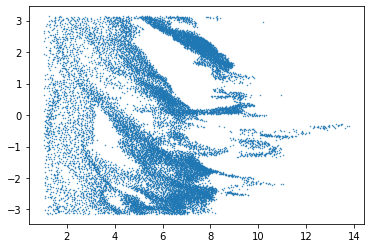

In [80]:
plt.scatter(r_data,polar_data['theta'] , s=0.2) 

In [72]:
def walk_through_particles(data):
    # Aquí irías recorriendo las partículas y haciendo un análisis del gradiente de deltaRho
    
    
    particle_paths = []
    for i, particle in data.iterrows():
        # Puedes añadir condiciones o análisis adicionales de la trayectoria de cada partícula
        
        
        particle_paths.append(particle)
    return particle_paths

# Ejemplo de uso:
particle_paths = walk_through_particles(sorted_data)


In [70]:
import skimage
print(skimage.__version__)


0.14.0


In [71]:


# Crear una malla 2D a partir de los datos
# Supongamos que tienes tus datos de x, y, y deltaRho en sorted_data
x = sorted_data['x']
y = sorted_data['y']
delta_rho = sorted_data['deltaRho']

# Crear una grilla 2D de densidad (usando histograma 2D o interpolación)
grid_size = 100  # Ajustar el tamaño de la malla
H, xedges, yedges = np.histogram2d(x, y, bins=grid_size, weights=delta_rho)

# Suavizar la función de densidad
smoothed_density = ndi.gaussian_filter(H, sigma=1.0)

# Detectar máximos locales
local_maxi = peak_local_max(smoothed_density, indices=False, footprint=np.ones((3, 3)))

# Generar un marcador para el algoritmo de Watershed
markers, _ = ndi.label(local_maxi)

# Aplicar el Watershed transform
labels = watershed(-smoothed_density, markers, mask=smoothed_density)

# Graficar los resultados
plt.figure(figsize=(10, 8))
plt.imshow(smoothed_density, cmap='plasma', origin='lower')
plt.contour(labels, colors='white', linewidths=1)
plt.colorbar(label='Densidad $\Delta \rho$')
plt.title('Segmentation using Watershed Transform')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.show()


NameError: name 'peak_local_max' is not defined